In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
from sklearn.neighbors import KDTree
import tsfresh as ts 
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge
import numpy as np
import pymc
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute


files = pd.read_excel('/home/velaraptor/Downloads/Raw Data 10yrs (2018).xlsx', header=1)

In [2]:
files = files.fillna(0)
groups = files.groupby('Name')

import tqdm

forecast_df = []
for name, group in tqdm.tqdm(groups):
    if len(group) > 1:
        group.index = group.Year
        df_shift, y = make_forecasting_frame(group["FantPt"], kind=name, max_timeshift=10, rolling_direction=1)
        forecast_df.append(df_shift)

100%|██████████| 2011/2011 [01:18<00:00, 24.86it/s]


In [3]:
f = files[files['Year'] != 2018]

test_f = files[files['Year'] ==2018].Name.unique()

test_ff = files[files['Name'].isin(test_f)]

In [4]:
for i in np.arange(2013, 2018, 1):
    print(i)

2013
2014
2015
2016
2017


In [6]:
training = []
for i in np.arange(2013, 2018, 1):
    files_temp = files[files['Year'] < i]
    extracted_features = extract_features(files_temp[['Year', 'Name', 'PPG', 'FantPt']], column_id="Name", column_sort="Year", default_fc_parameters=EfficientFCParameters())
    t_temp = extracted_features.reset_index()
    
    extracted_features = extracted_features.merge(files[(files['Year']==i)][['Name', 'Age', 'FantPt']], right_on='Name', left_on='id')
    extracted_features = extracted_features.dropna(subset=['FantPt'])
    ts_features = extracted_features.reset_index(drop=True)
    training.append(extracted_features)
    

training_df = pd.concat(training)
training_df = training_df.reset_index(drop=True)
ts_features = training_df.dropna(axis=1)



Feature Extraction: 100%|██████████| 20/20 [01:13<00:00,  2.02s/it]


In [7]:
test_features = extract_features(test_ff[['Year', 'Name', 'PPG', 'FantPt']], column_id="Name", column_sort="Year", default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:27<00:00,  1.03it/s]


In [9]:
ts_features_test = test_features.reset_index()
ts_features_test = ts_features_test.dropna(axis=1)

In [209]:
columns = np.append(ts_features.columns[2:len(ts_features.columns)-3].values, 'Age')
ada = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(loss='lad', max_depth=15, n_estimators=25, alpha=0.985), n_estimators=10, loss='exponential')
ada.fit(ts_features[columns], ts_features['FantPt'])

AdaBoostRegressor(base_estimator=GradientBoostingRegressor(alpha=0.985,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.1,
                                                           loss='lad',
                                                           max_depth=15,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                           min_w

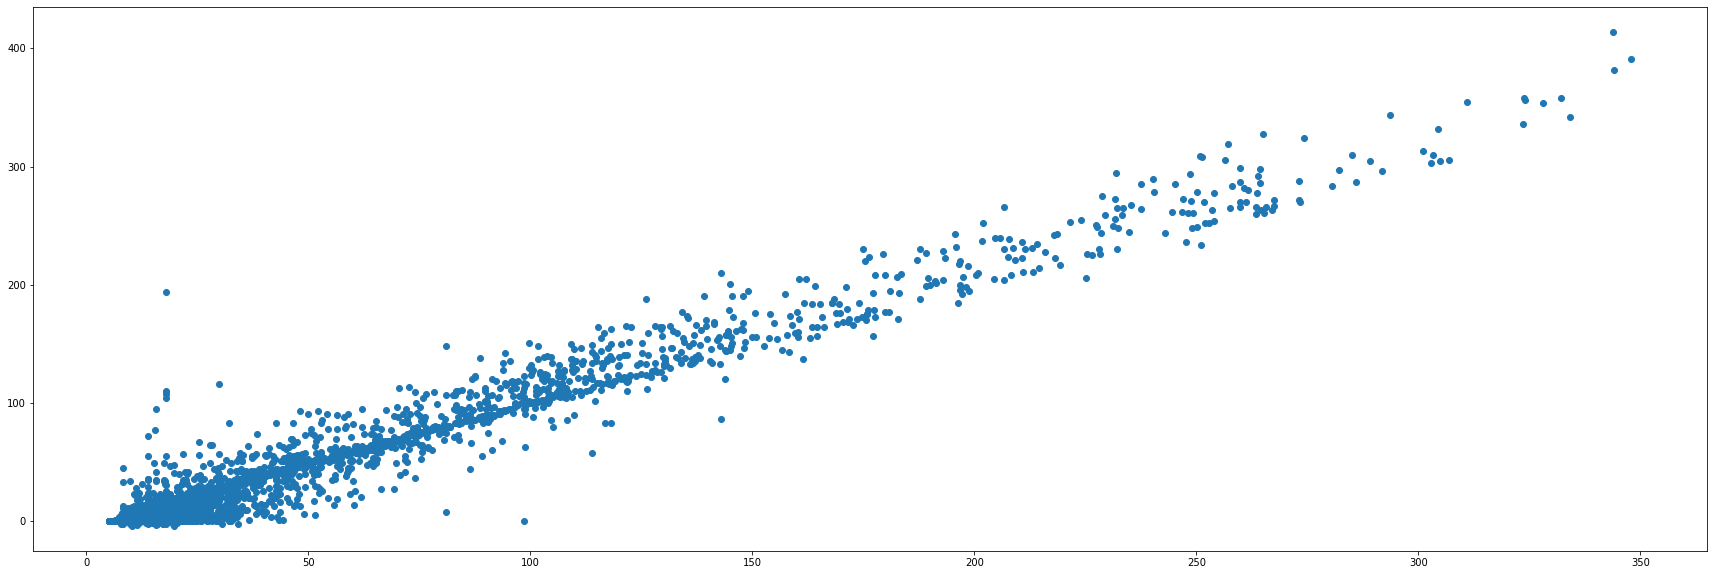

In [210]:
fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(ada.predict(ts_features[columns]), ts_features['FantPt'])
plt.show()

In [211]:
pd.DataFrame([ada.predict(ts_features[columns]), ts_features['FantPt']]).T

,0,1
0,183.404813,209.0
1,13.822475,14.0
2,182.729804,171.0
3,192.916157,204.0
4,17.917762,0.0
5,37.956530,35.0
6,47.576921,48.0
7,20.984944,4.0
8,221.607847,253.0
9,11.502021,7.0


In [212]:
from sklearn.metrics import median_absolute_error
median_absolute_error(ts_features['FantPt'], ada.predict(ts_features[columns]))

9.28929107558017

In [213]:
ts_features_test['Age'] = ts_features_test.Age_x

In [214]:
# ts_features_test = ts_features_test.merge(files[(files['Year']==2018)][['Name', 'Age', 'FantPt']], right_on='Name', left_on='id')
final_predictions = pd.DataFrame({'Name': ts_features_test.id, 'prediction': ada.predict(ts_features_test[columns])})



In [215]:
final_predictions = final_predictions.merge(files[['Name', 'FantPos']].drop_duplicates(), on='Name', how='right').drop_duplicates('Name')

In [216]:
final_predictions.max()

Name          Zurlon Tipton
prediction          279.261
dtype: object

In [217]:
idx_1 = final_predictions.groupby(['FantPos'])['prediction'].transform(max) == final_predictions['prediction']

final_predictions[idx_1]

,Name,prediction,FantPos
19,Alex Smith,148.478406,TE
111,Case Keenum,145.578490,0
435,Kenny Golladay,145.398103,WR
577,Phillip Lindsay,230.011512,RB
621,Russell Wilson,279.261277,QB


In [218]:
final_predictions_1 = final_predictions[~np.isnan(final_predictions['prediction'])]

In [219]:
final_predictions_1[final_predictions_1['FantPos'] ==  'QB'].sort_values('prediction', ascending=False).values

array([['Russell Wilson', 279.261276762067, 'QB'],
       ['Cam Newton', 272.90227023674885, 'QB'],
       ['Philip Rivers', 244.88329497020428, 'QB'],
       ['Derek Carr', 237.07466291070452, 'QB'],
       ['Tom Brady', 227.61666699969285, 'QB'],
       ['Josh Allen', 220.4505601791897, 'QB'],
       ['Matthew Stafford', 219.25513111837046, 'QB'],
       ['Blake Bortles', 218.75702340493402, 'QB'],
       ['Andrew Luck', 214.5855988309812, 'QB'],
       ['Andy Dalton', 212.83747605494707, 'QB'],
       ['Eli Manning', 210.32322333391056, 'QB'],
       ['Marcus Mariota', 206.8097930687221, 'QB'],
       ['Carson Wentz', 204.72943172462666, 'QB'],
       ['Dak Prescott', 201.8480092351143, 'QB'],
       ['Drew Brees', 201.65209016559947, 'QB'],
       ['Jameis Winston', 200.6699137505609, 'QB'],
       ['Aaron Rodgers', 191.7639345778395, 'QB'],
       ['Ben Roethlisberger', 189.60830811776125, 'QB'],
       ['Sam Darnold', 188.37214307697647, 'QB'],
       ['Kirk Cousins', 186.0836558

In [220]:
final_predictions_1[final_predictions_1['FantPos'] ==  'RB'].sort_values('prediction', ascending=False).values

array([['Phillip Lindsay', 230.01151234780073, 'RB'],
       ['Nick Chubb', 184.71492657454618, 'RB'],
       ['Tevin Coleman', 164.20848751516618, 'RB'],
       ['Jordan Howard', 163.25729768872887, 'RB'],
       ['Kareem Hunt', 162.68746678860393, 'RB'],
       ['Derrick Henry', 151.09445976431158, 'RB'],
       ['Saquon Barkley', 150.5932566646732, 'RB'],
       ['Chris Carson', 146.73766078694513, 'RB'],
       ['Kenyan Drake', 143.98470217748937, 'RB'],
       ['Alvin Kamara', 142.26196927105224, 'RB'],
       ['Austin Ekeler', 141.80991206106197, 'RB'],
       ['Aaron Jones', 139.79665828900426, 'RB'],
       ['Gus Edwards', 138.4307971513466, 'RB'],
       ['Latavius Murray', 137.85359856513963, 'RB'],
       ['Lamar Miller', 136.73043103356218, 'RB'],
       ['Joe Mixon', 134.8388793946928, 'RB'],
       ['Elijah McGuire', 133.20363904798918, 'RB'],
       ['Royce Freeman', 130.9194326530848, 'RB'],
       ['Dalvin Cook', 130.67289678827993, 'RB'],
       ['Matt Breida', 130.51

In [221]:
final_predictions_1[final_predictions_1['FantPos'] ==  'WR'].sort_values('prediction', ascending=False).values

array([['Kenny Golladay', 145.39810336342927, 'WR'],
       ['Chris Godwin', 144.58626309377064, 'WR'],
       ['Jarvis Landry', 142.55910613525566, 'WR'],
       ['Anthony Miller', 137.18265944690705, 'WR'],
       ['Zay Jones', 135.72326864468124, 'WR'],
       ['Antonio Brown', 133.67516194822707, 'WR'],
       ['Tarik Cohen', 132.0183023197869, 'WR'],
       ['Amari Cooper', 131.16857968762017, 'WR'],
       ['Odell Beckham', 130.61862370265598, 'WR'],
       ['Dede Westbrook', 129.84733198112292, 'WR'],
       ['Adam Thielen', 129.48010216407715, 'WR'],
       ['Adam Humphries', 128.07513190170096, 'WR'],
       ['Tyler Boyd', 127.79862754347873, 'WR'],
       ['Robby Anderson', 126.53645667325144, 'WR'],
       ['Courtland Sutton', 125.83074469098412, 'WR'],
       ['Stefon Diggs', 123.0361497030723, 'WR'],
       ['Julian Edelman', 122.06786006435942, 'WR'],
       ['Mike Evans', 121.47016170070195, 'WR'],
       ['Tim Patrick', 120.70537314512003, 'WR'],
       ['DeAndre Hopkin

In [222]:
final_predictions_1[final_predictions_1['FantPos'] ==  'TE'].sort_values('prediction', ascending=False).values

array([['Alex Smith', 148.47840556267982, 'TE'],
       ['Dallas Goedert', 148.27633778294918, 'TE'],
       ['Jason Croom', 136.8758342270645, 'TE'],
       ['Mo Alie-Cox', 115.82682098024468, 'TE'],
       ['Chris Herndon', 114.39472431378682, 'TE'],
       ['Mark Andrews', 114.39472431378682, 'TE'],
       ['O.J. Howard', 107.3470437147691, 'TE'],
       ['Hayden Hurst', 104.44802098024468, 'TE'],
       ['Blake Jarwin', 102.3782909000299, 'TE'],
       ['Demetrius Harris', 101.38704423636818, 'TE'],
       ['Jack Doyle', 100.21169340364752, 'TE'],
       ['Ricky Seals-Jones', 99.51844767099675, 'TE'],
       ['Delanie Walker', 99.45754586562958, 'TE'],
       ['Gerald Everett', 98.50900709774513, 'TE'],
       ['Geoff Swaim', 96.07574325689066, 'TE'],
       ['Matt LaCosse', 94.39822135811617, 'TE'],
       ['Evan Engram', 93.96602769218156, 'TE'],
       ['David Grinnage', 93.86369971226122, 'TE'],
       ['Alex Ellis', 92.65913879734738, 'TE'],
       ['Jordan Thomas', 92.3901393

In [223]:
files[files['Name']=='Odell Beckham']['FantPt']

3604    204.0
4514    223.0
5110    196.0
5803     53.0
6118    153.0
Name: FantPt, dtype: float64

In [224]:
final_predictions_1[final_predictions_1['Name']=='Odell Beckham']['prediction']

565    130.618624
Name: prediction, dtype: float64

In [58]:
tree = KDTree(ts_features[columns])

In [88]:
ts_features_test.columns

Index(['id', 'FantPt__abs_energy', 'FantPt__absolute_sum_of_changes',
       'FantPt__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'FantPt__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'FantPt__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'FantPt__binned_entropy__max_bins_10', 'FantPt__c3__lag_1',
       'FantPt__c3__lag_2', 'FantPt__c3__lag_3',
       ...
       'PPG__value_count__value_1', 'PPG__variance',
       'PPG__variance_larger_than_standard_deviation', 'Name_x', 'Age_x',
       'FantPt_x', 'Name_y', 'Age_y', 'FantPt_y', 'Age'],
      dtype='object', length=470)

In [76]:
dist, ind = tree.query(ts_features_test[ts_features_test['id']=='Dak Prescott'][columns].iloc[0].values.reshape(1,-1), k=10) 

In [77]:
ind

array([[1508,  371, 1029, 1408, 1867,   31,  506,  497,  258, 2283]])

In [86]:
ts_features.loc[ind[0]]['FantPt'].quantile(0.95)

381.5999999999999

In [79]:
import pickle

In [225]:
# save column names and pickle files

filename = 'kd_tree.pkl'
pickle.dump({'model': tree, 'columns': columns}, open(filename, 'wb'))


filename = 'adaboost.pkl'
pickle.dump({'model': ada, 'columns': columns}, open(filename, 'wb'))

# save predictions and files 




In [226]:
ts_features.to_csv('all_data_before_2018.csv', index=False)

In [227]:
ts_features_test.to_csv('2018.csv', index=False)

In [228]:
final_predictions_1.to_csv('predictions_2018.csv', index=False)

In [197]:
def get_kd_tree_predictions(kd, test, train, f):
    preds = []
    for index, row in test.iterrows():
        dist, ind = kd.query(row[f].values.reshape(1,-1), k=20)
        median = train.loc[ind[0]]['FantPt'].median()
        high = train.loc[ind[0]]['FantPt'].quantile(0.90)
        low = train.loc[ind[0]]['FantPt'].quantile(0.1)
        name = row['id']
        p_one = {'point': median, 'high': high, 'low': low, 'Name': name}
        preds.append(p_one)
    return preds
        
        

In [198]:
kd_predictions = get_kd_tree_predictions(tree, ts_features_test, ts_features, columns)

In [199]:
ts_features.head()

,FantPt__abs_energy,FantPt__absolute_sum_of_changes,"FantPt__agg_autocorrelation__f_agg_""mean""__maxlag_40","FantPt__agg_autocorrelation__f_agg_""median""__maxlag_40","FantPt__agg_autocorrelation__f_agg_""var""__maxlag_40",FantPt__binned_entropy__max_bins_10,FantPt__c3__lag_1,FantPt__c3__lag_2,FantPt__c3__lag_3,"FantPt__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0",...,PPG__time_reversal_asymmetry_statistic__lag_2,PPG__time_reversal_asymmetry_statistic__lag_3,PPG__value_count__value_-1,PPG__value_count__value_0,PPG__value_count__value_1,PPG__variance,PPG__variance_larger_than_standard_deviation,Name,Age,FantPt
0,64618.0,50.0,-1.000000,-1.000000,0.000000,0.693147,0.0,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.546914,1.0,A.J. Green,25.0,209.0
1,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.0,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,A.J. Jenkins,24.0,14.0
2,581990.0,248.0,-0.272206,-0.319571,0.272904,1.332179,38882502.0,3.115814e+07,0.0,0.0,...,2448.000000,0.000000,0.0,0.0,0.0,7.199625,1.0,Aaron Rodgers,30.0,171.0
3,334896.0,1200.0,-0.093114,-0.158095,0.444501,1.549826,3169264.8,1.301236e+07,458658.0,0.0,...,357.806228,53.986607,0.0,0.0,1.0,55.318410,1.0,Adrian Peterson,28.0,204.0
4,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.0,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,Adrien Robinson,25.0,0.0


In [229]:
kd_pred = pd.DataFrame(kd_predictions)

In [230]:
kd_pred = kd_pred.merge(files[['Name', 'FantPos']].drop_duplicates(), on='Name', how='right').drop_duplicates('Name')

kd_pred = kd_pred[~np.isnan(kd_pred['point'])]

In [231]:
kd_pred_qb = kd_pred[kd_pred['FantPos'] == 'QB']
kd_pred_rb = kd_pred[kd_pred['FantPos'] == 'RB']
kd_pred_te = kd_pred[kd_pred['FantPos'] == 'TE']
kd_pred_wr = kd_pred[kd_pred['FantPos'] == 'WR']
kd_pred_none = kd_pred[kd_pred['FantPos'] == 0]



ada_pred_qb = final_predictions_1[final_predictions_1['FantPos'] == 'QB']
ada_pred_rb = final_predictions_1[final_predictions_1['FantPos'] == 'RB']
ada_pred_te = final_predictions_1[final_predictions_1['FantPos'] == 'TE']
ada_pred_wr = final_predictions_1[final_predictions_1['FantPos'] == 'WR']
ada_pred_none = final_predictions_1[final_predictions_1['FantPos'] == 0]


In [232]:
kd_pred_qb.sort_values('point', ascending=False).head()

,Name,high,low,point,FantPos
5,Aaron Rodgers,354.1,222.9,279.0,QB
102,Cam Newton,337.9,188.9,269.0,QB
248,Drew Brees,354.1,222.9,269.0,QB
468,Logan Thomas,320.3,109.8,264.5,QB
621,Russell Wilson,337.9,188.9,264.5,QB


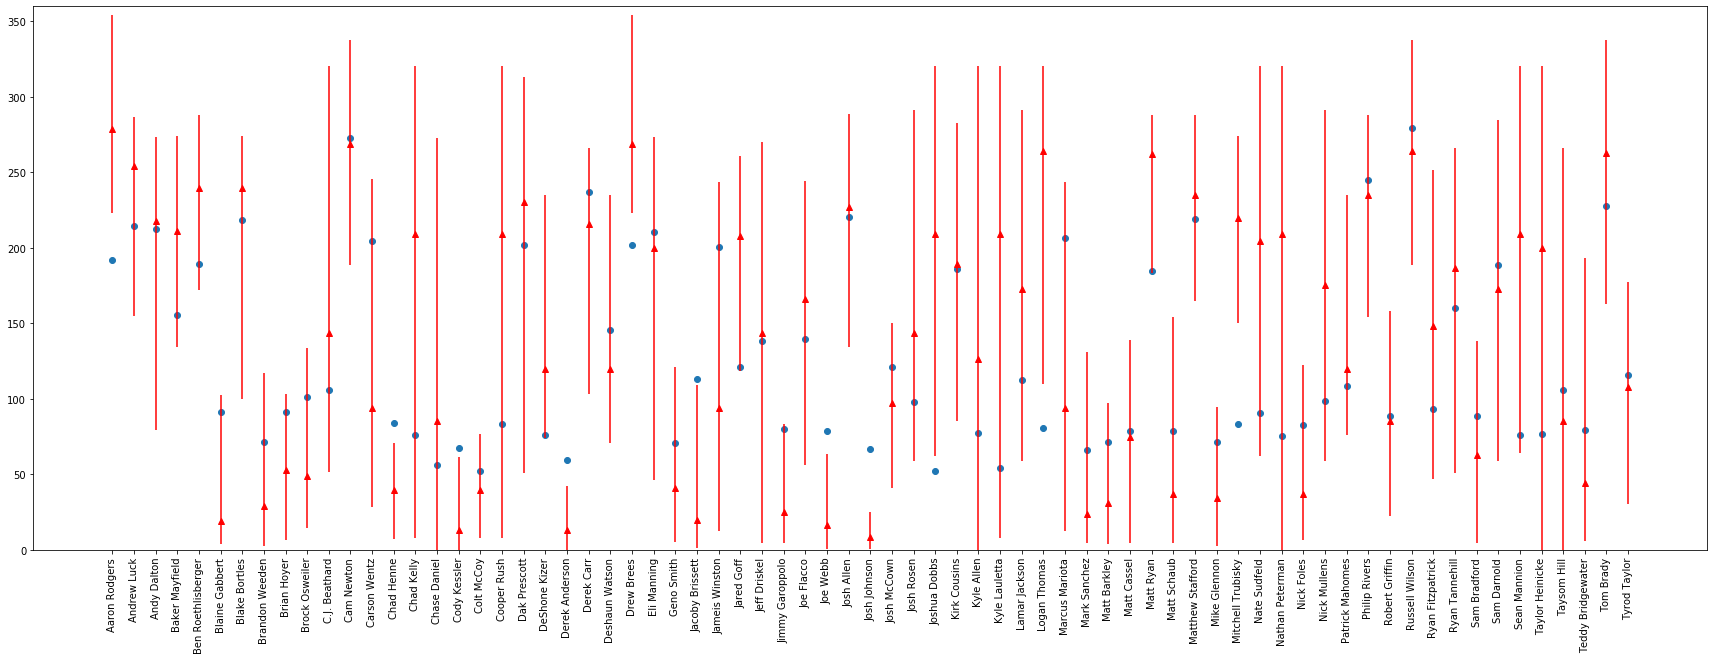

In [249]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_qb['Name'], kd_pred_qb['point'], np.array([kd_pred_qb['point']- kd_pred_qb['low'], kd_pred_qb['high'] - kd_pred_qb['point']]), fmt='r^')
plt.scatter(ada_pred_qb['Name'], ada_pred_qb['prediction'])
plt.xticks(rotation=90)
plt.ylim([0, 360])
plt.show()

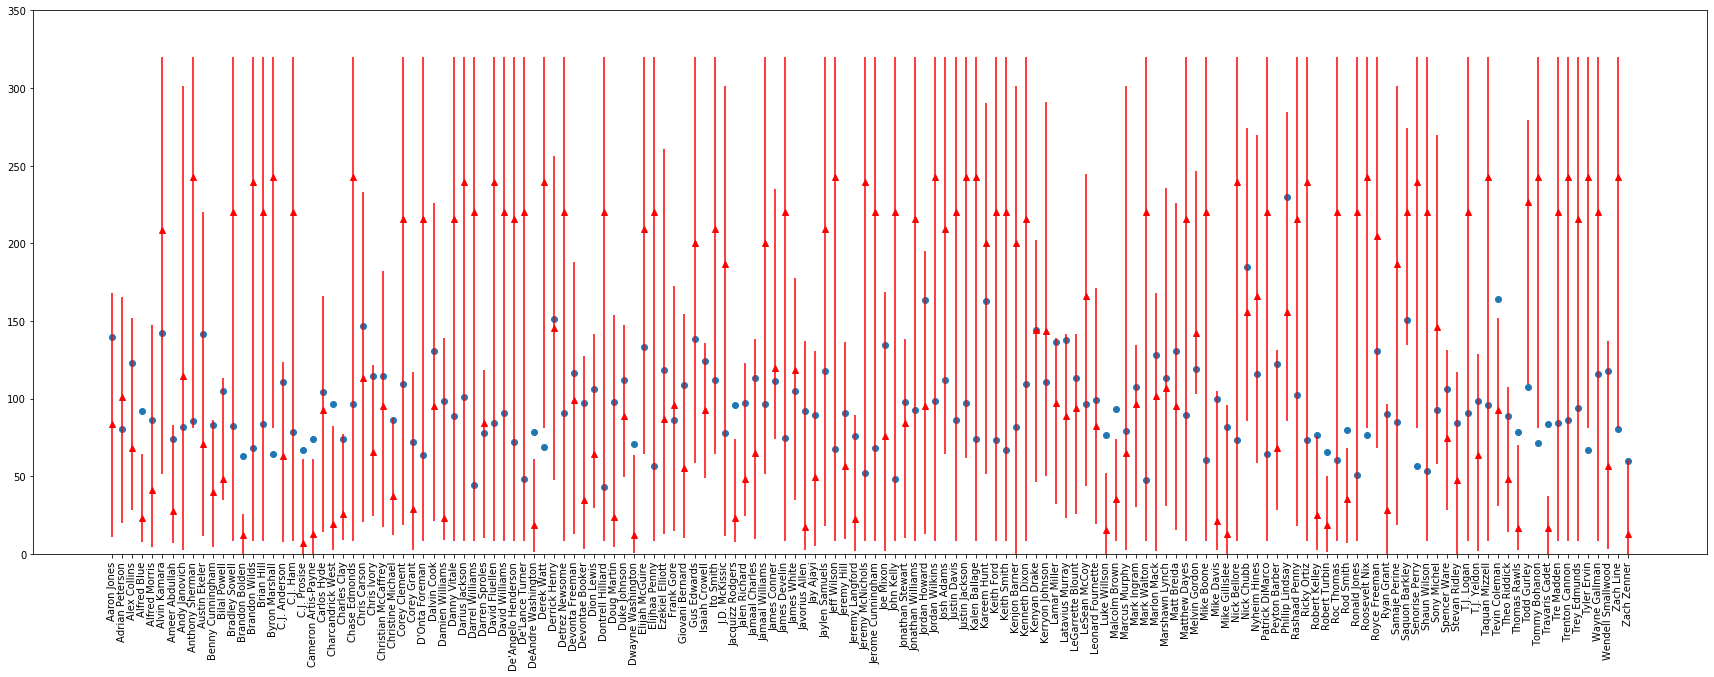

In [247]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_rb['Name'], kd_pred_rb['point'], np.array([kd_pred_rb['point']- kd_pred_rb['low'], kd_pred_rb['high'] - kd_pred_rb['point']]), fmt='r^')
plt.scatter(ada_pred_rb['Name'], ada_pred_rb['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 350])

plt.show()

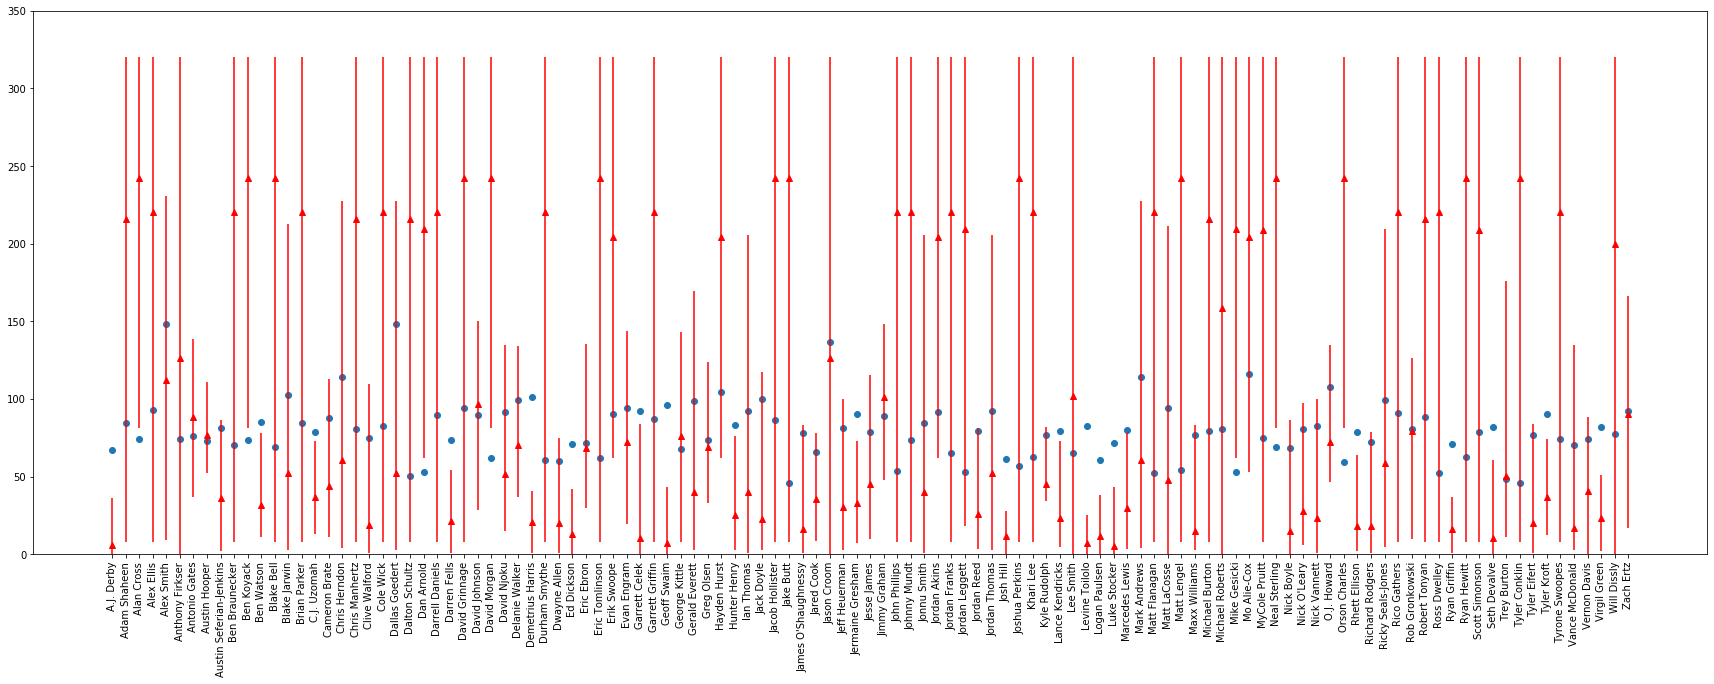

In [246]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_te['Name'], kd_pred_te['point'], np.array([kd_pred_te['point']- kd_pred_te['low'], kd_pred_te['high'] - kd_pred_te['point']]), fmt='r^')
plt.scatter(ada_pred_te['Name'], ada_pred_te['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 350])

plt.show()

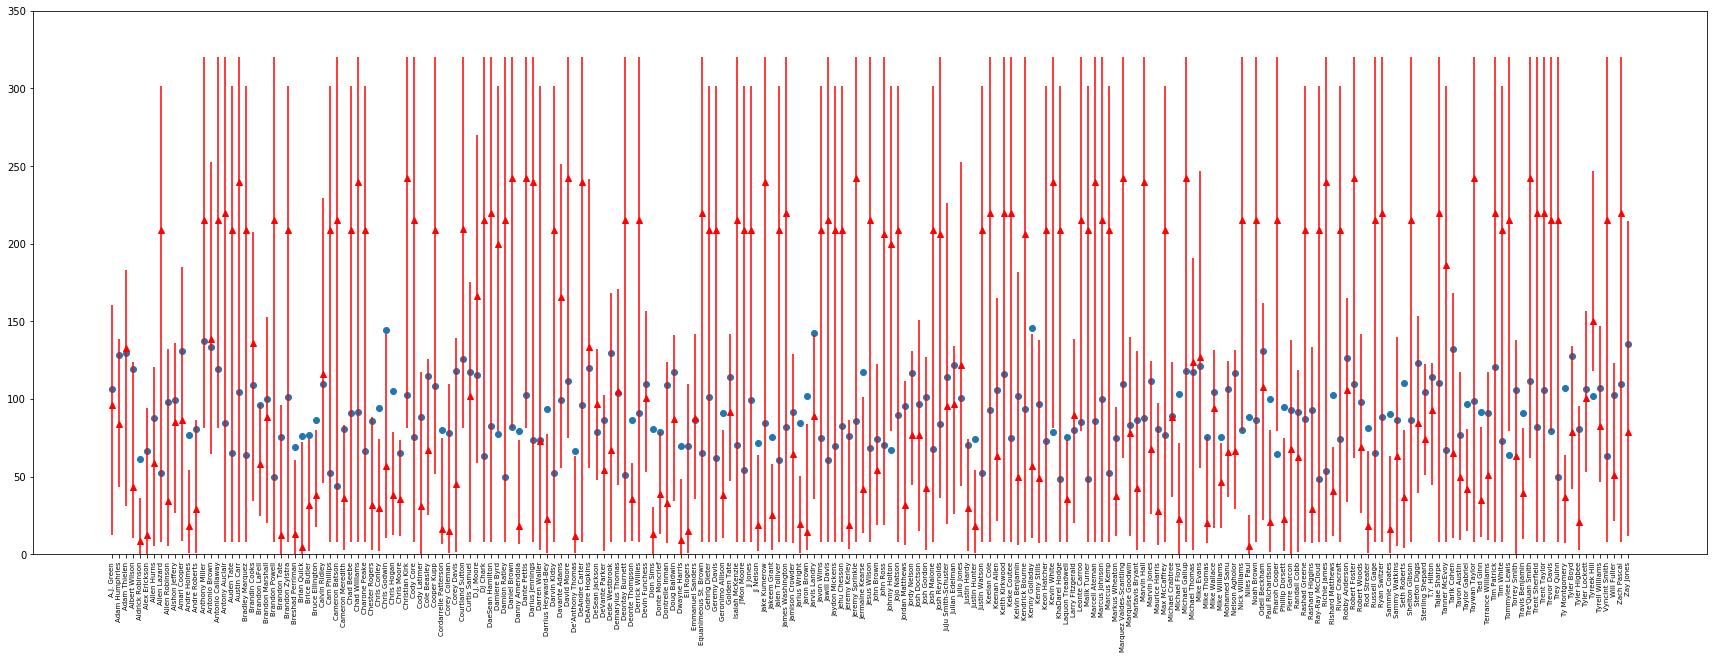

In [245]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_wr['Name'], kd_pred_wr['point'], np.array([kd_pred_wr['point']- kd_pred_wr['low'], kd_pred_wr['high'] - kd_pred_wr['point']]), fmt='r^')
plt.scatter(ada_pred_wr['Name'], ada_pred_wr['prediction'])

plt.xticks(rotation=90,size=7)
plt.ylim([0, 350])

plt.show()

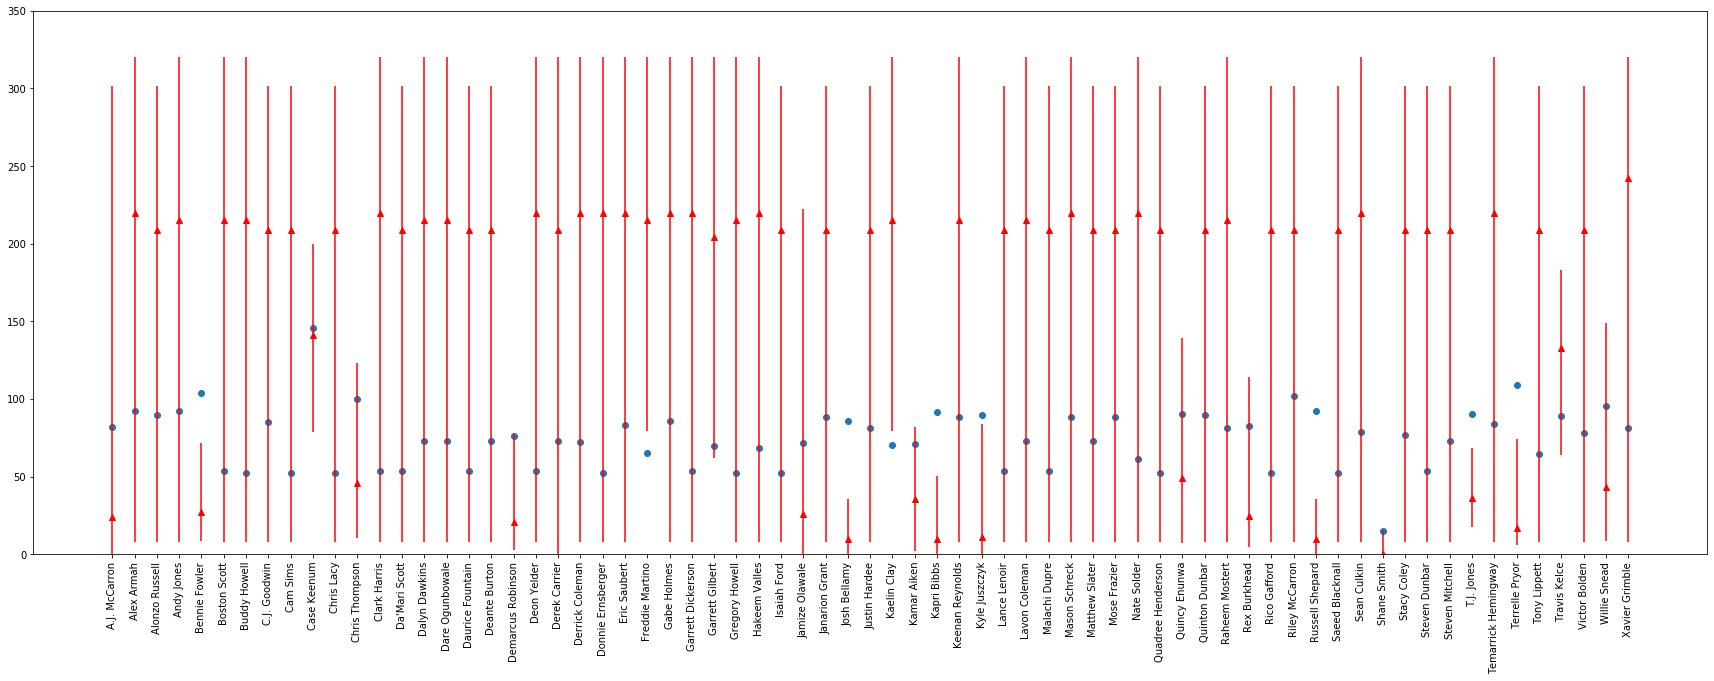

In [244]:


fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_none['Name'], kd_pred_none['point'], np.array([kd_pred_none['point']- kd_pred_none['low'], kd_pred_none['high'] - kd_pred_none['point']]), fmt='r^')
plt.scatter(ada_pred_none['Name'], ada_pred_none['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 350])

plt.show()

In [250]:
all_predictions_kd_ada = kd_pred.merge(final_predictions_1[['Name', 'prediction']], on='Name')

#final_predictions_1

In [251]:
all_predictions_kd_ada.groupby('FantPos')['point'].nlargest(10).index


MultiIndex(levels=[[0, 'QB', 'RB', 'TE', 'WR'], [4, 9, 12, 29, 35, 47, 48, 54, 55, 78, 86, 104, 116, 119, 150, 153, 167, 169, 170, 188, 195, 205, 211, 225, 226, 232, 234, 249, 262, 265, 295, 301, 329, 343, 351, 354, 397, 415, 427, 428, 440, 507, 517, 522, 559, 565, 577, 578, 586, 616]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [49, 2, 13, 19, 20, 21, 23, 25, 26, 27, 0, 10, 22, 36, 43, 46, 39, 3, 6, 8, 4, 9, 11, 30, 32, 34, 35, 42, 44, 47, 1, 5, 7, 16, 18, 24, 28, 29, 33, 38, 12, 14, 15, 17, 31, 37, 40, 41, 45, 48]],
           names=['FantPos', None])

In [252]:
all_predictions_kd_ada.to_csv('all_predictions.csv', index=False)

In [253]:
files[files['Name']=='Andy Janovich']

,Year,Name,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,Tgt,Rec,Yds.2,Y/R,TD.2,FantPt,PPR,PPG,PPRPG,PosRank
5265,2016,Andy Janovich,DEN,RB,23.0,11.0,5.0,0.0,0.0,0.0,...,7.0,5.0,44.0,8.80,0.0,14.0,19.0,1.272727,1.727273,107.0
5826,2017,Andy Janovich,DEN,RB,24.0,16.0,4.0,0.0,0.0,0.0,...,6.0,4.0,35.0,8.75,0.0,11.0,15.0,0.687500,0.937500,114.0
6393,2018,Andy Janovich,DEN,RB,25.0,16.0,7.0,0.0,0.0,0.0,...,10.0,8.0,112.0,14.00,1.0,18.0,25.7,90.000000,0.000000,0.0


In [254]:
all_predictions_kd_ada[all_predictions_kd_ada['Name']=='Andy Janovich']

,Name,high,low,point,FantPos,prediction
31,Andy Janovich,301.4,2.7,114.5,RB,81.786417


In [257]:
all_predictions_kd_ada['band']= all_predictions_kd_ada.high - all_predictions_kd_ada.low

In [260]:
all_predictions_kd_ada[all_predictions_kd_ada.band  == all_predictions_kd_ada.band.min()]

,Name,high,low,point,FantPos,prediction,band
542,Shane Smith,15.2,0.0,0.0,0,15.262641,15.2


In [261]:
all_predictions_kd_ada.sort_values('band', ascending=False)

,Name,high,low,point,FantPos,prediction,band
441,Michael Roberts,320.3,0.0,158.5,TE,80.332376,320.3
193,Derek Carrier,320.3,0.0,209.0,0,72.878096,320.3
563,Taylor Heinicke,320.3,0.0,200.0,QB,76.506559,320.3
392,Lee Smith,320.3,0.0,102.0,TE,65.299159,320.3
33,Anthony Firkser,320.3,0.0,126.5,TE,73.902341,320.3
459,Nathan Peterman,320.3,0.0,209.5,QB,75.139785,320.3
378,Kyle Allen,320.3,0.0,126.5,QB,77.117215,320.3
613,Will Dissly,320.3,0.0,200.0,TE,77.117215,320.3
286,Jason Croom,320.3,0.0,126.5,TE,136.875834,320.3
172,David Williams,320.3,8.1,220.0,RB,91.048888,312.2


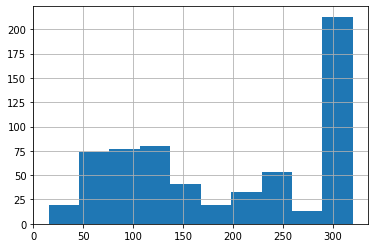

In [262]:
all_predictions_kd_ada.band.hist()